# Use emcee to sample Lya posterior as a function of mean flux

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
# temporal
import camb
# our own modules
import simplest_emulator
import linear_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import camb_cosmo
import fit_linP
import recons_cosmo
import compute_likelihood

## Setup Lya likelihood function

In [2]:
# read P1D measurement
basedir='../../p1d_data/data_files/PD2013/'
data=data_PD2013.P1D_PD2013(basedir=basedir,blind_data=True)
zs=data.z
Nz=len(zs)

In [3]:
# load P1D emulator
basedir='/Users/font/CosmoData/test_sim_emulator/test_medium/'
#basedir='../mini_sim_suite/'
p1d_label='mf_p1d'
skewers_label='Ns100_wM0.05'
#emu=simplest_emulator.SimplestEmulator(basedir,p1d_label,skewers_label,max_arxiv_size=10000,verbose=False)
emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,max_arxiv_size=300,verbose=False)

setup interpolator for coefficient 0
[ 0.3        -2.29500051 -0.21000061  0.98394565  0.50560665  0.13055504
  1.42675044] test [-0.9793026]
setup interpolator for coefficient 1
[ 0.3        -2.29500051 -0.21000061  0.98394565  0.50560665  0.13055504
  1.42675044] test [-0.63083161]
setup interpolator for coefficient 2
[ 0.3        -2.29500051 -0.21000061  0.98394565  0.50560665  0.13055504
  1.42675044] test [-0.25119308]
setup interpolator for coefficient 3
[ 0.3        -2.29500051 -0.21000061  0.98394565  0.50560665  0.13055504
  1.42675044] test [-0.10792213]
setup interpolator for coefficient 4
[ 0.3        -2.29500051 -0.21000061  0.98394565  0.50560665  0.13055504
  1.42675044] test [-0.01876241]


In [4]:
# setup nuisance models
mf_model=mean_flux_model.MeanFluxModel()
T_model=thermal_model.ThermalModel()

In [5]:
# specify cosmology
cosmo = camb_cosmo.get_cosmology(mnu=0.15, ns=0.965, omch2=0.12)
# print relevant information about the cosmology object
camb_cosmo.print_info(cosmo)
# compute linear power parameters, around z_star and kp_kms
z_star=3.0
kp_kms=0.009
linP_model=fit_linP.LinearPowerModel(cosmo,z_star=z_star,k_units='kms',kp=kp_kms)
linP_model.get_params()

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 1.6128E-03, T_CMB = 2.7255E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00


{'Delta2_star': 0.34359089153174016,
 'alpha_star': -0.21586983258446132,
 'f_star': 0.97514327990258953,
 'g_star': 0.968209492732573,
 'n_star': -2.300572652881717}

In [6]:
# setup fiducial cosmology
cosmo_fid = camb_cosmo.get_cosmology()
# reconstruct cosmology using linear parameter model (at z_star, kp_kms)
rec_cosmo=recons_cosmo.ReconstructedCosmology(linP_model,cosmo_fid)
# compute linear power parameters at each redshift (in Mpc)
linP_Mpc_params=rec_cosmo.get_linP_Mpc_params(zs)

Note: redshifts have been re-sorted (earliest first)


In [7]:
chi2=compute_likelihood.get_chi2(data,cosmo_fid,emu,rec_cosmo,mf_model,T_model,linP_Mpc_params)

In [8]:
chi2

7495.6653252878496

In [9]:
#cProfile.run("compute_likelihood.get_chi2(data,cosmo_fid,emu,rec_cosmo,mf_model,T_model,linP_Mpc_params)",sort='cumtime')

### Setup MCMC to call this function

In [10]:
def get_ln_tau_0(x):
    ln_tau_min=-1.05
    ln_tau_max=-0.75
    return ln_tau_min+x*(ln_tau_max-ln_tau_min)

In [11]:
def lnprob(x,data,cosmo_fid,emu,rec_cosmo,linP_Mpc_params):
    # for now priors are top hats in 0 < x < 1
    if max(x) > 1.0: 
        return -np.inf
    if min(x) < 0.0:
        return -np.inf
    ln_tau_0 = get_ln_tau_0(x[0])
    mf_model=mean_flux_model.MeanFluxModel(z_tau=3.0,ln_tau_coeff=[3.18,ln_tau_0])
    T_model=thermal_model.ThermalModel()
    # compute chi2        
    chi2=compute_likelihood.get_chi2(data,cosmo_fid,emu,rec_cosmo,mf_model,T_model,linP_Mpc_params)
    loglike=-0.5*chi2
    # add smooth, weak prior to alleviate NGP in likelihood
    loglike -= (x[0]-0.55)**2/0.01
    #print(x,'log like =',loglike)
    return -0.5*chi2

In [12]:
# for now we'll have only three dimensions (mean flux, temperature, gamma)
ndim=1
# setup initial walkers
nwalkers = 20
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

In [13]:
p0.flatten()

array([ 0.72070896,  0.1082309 ,  0.57754768,  0.06825566,  0.40596513,
        0.22812856,  0.193923  ,  0.03046219,  0.15919478,  0.7397228 ,
        0.84086161,  0.88826766,  0.0190968 ,  0.22981545,  0.96692033,
        0.7831957 ,  0.24758963,  0.72997009,  0.99559125,  0.84126732])

In [14]:
# test function
lnprob(p0[0],data,cosmo_fid,emu,rec_cosmo,linP_Mpc_params)

-3445.9902659996451

In [15]:
# setup sampler
emu.arxiv.verbose=False
emu.verbose=False
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[data,cosmo_fid,emu,rec_cosmo,linP_Mpc_params])

In [16]:
# burn-in phase
for i in range(1):
    pos, prob, state = sampler.run_mcmc(p0, 5)
    print(i,'finished at',pos.flatten(),prob)
    p0=pos

0 finished at [ 0.81519118  0.27853646  0.79645431  0.46110471  0.83319445  0.57612709
  0.37457783  0.15168477  0.28058867  0.81972802  0.82387433  0.8139599
  0.09406736  0.74798311  0.86656509  0.79962231  0.47312928  0.78937427
  0.86148208  0.84126732] [-3429.1480122  -4112.86824393 -3428.98711181 -3646.32141349 -3432.46892224
 -3525.96066841 -3813.4327492  -4617.57811598 -4105.63220829 -3429.65042306
 -3430.17432091 -3428.99495123 -4874.94770605 -3440.209687   -3446.86582277
 -3428.50449386 -3630.3964354  -3431.36628158 -3443.16585041 -3434.90313986]


In [17]:
# reset and run actual chains
sampler.reset()
nsteps=100
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    if i % 100 == 0:
        print(i,result[0].flatten())

0 [ 0.80638095  0.27853646  0.79645431  0.46110471  0.83107219  0.58015031
  0.59395094  0.44098001  0.28058867  0.83241098  0.81146832  0.8139599
  0.45999617  0.74798311  0.85387522  0.79962231  0.48132826  0.78937427
  0.85110756  0.81752897]


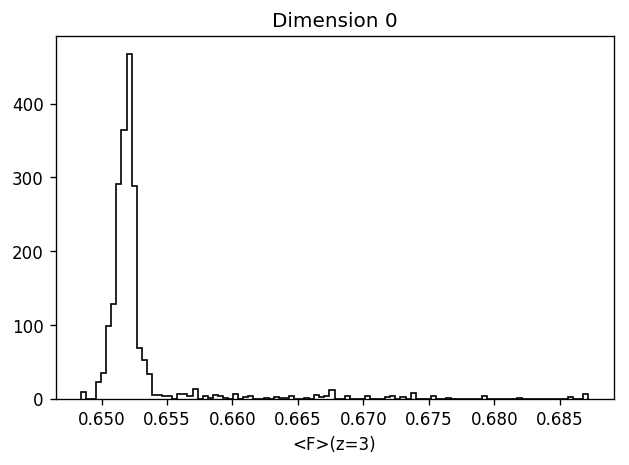

In [18]:
for i in range(ndim):
    plt.figure()
    plt.hist(np.exp(-np.exp(get_ln_tau_0(sampler.flatchain[:,i]))), 100, color="k", histtype="step")
    plt.xlabel('<F>(z=3)')
    plt.title("Dimension {0:d}".format(i))

In [19]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.738


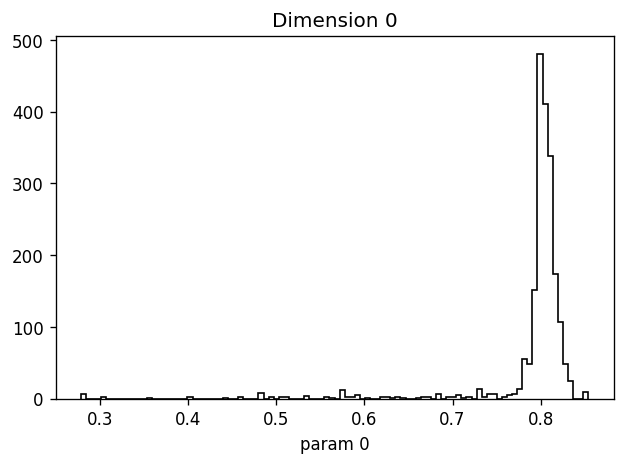

In [26]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.xlabel('param 0')
    plt.title("Dimension {0:d}".format(i))

In [21]:
xs=np.linspace(0.0,1.0,100)

In [22]:
lnps=[lnprob([x],data,cosmo_fid,emu,rec_cosmo,linP_Mpc_params) for x in xs]

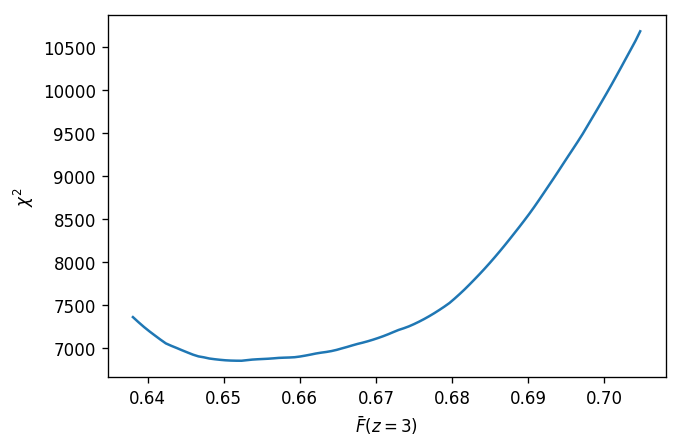

In [23]:
plt.plot(np.exp(-np.exp(get_ln_tau_0(xs))),-2.0*np.array(lnps))
plt.xlabel(r'$\bar F(z=3)$')
plt.ylabel(r'$\chi^2$')

In [25]:
lnps

[-5343.5749058478104,
 -5287.68064209968,
 -5236.7760508727606,
 -5186.0811434157777,
 -5134.9357948543511,
 -5084.4745310363423,
 -5034.403068473528,
 -4985.5495770936068,
 -4937.4561534139475,
 -4889.7717400003621,
 -4842.5369598261723,
 -4795.1813462075952,
 -4747.8974345189799,
 -4703.7459770118294,
 -4660.7875120273939,
 -4618.2878125761372,
 -4575.1813113327607,
 -4531.6856657213284,
 -4488.8658230271485,
 -4446.7362700188987,
 -4404.4974931292372,
 -4362.4829119243686,
 -4321.2070754214328,
 -4281.588097935437,
 -4243.5603025410564,
 -4206.3133467723801,
 -4169.863425911275,
 -4133.5388869623548,
 -4097.7751218168232,
 -4062.8589299791938,
 -4028.8076154775977,
 -3995.6387640504236,
 -3963.4135821422565,
 -3932.1645987643569,
 -3901.8515557447863,
 -3872.0712298495491,
 -3843.0924441402581,
 -3815.6592194751011,
 -3789.3522001935444,
 -3764.2444015148467,
 -3743.4933327843382,
 -3723.9129982022264,
 -3705.221423258517,
 -3687.6068210677799,
 -3671.0924654259643,
 -3655.702080340